In [1]:
import numpy as np
import numpy.random as rng
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import math 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data generators and model specifications

# X
X is generated and normalized as in low dimension case.

In [2]:
p = 200 # number of dimension
N = 50 # sample size
rho = 0 # correlation between features

In [3]:
X = np.load('./data/X_rho0_N50_p200.npy')

## Sparse linear model
$\gamma_j \sim Bernoulli(\theta)$ (We fix $\theta=0.05$ currently, but we can also add a prior on $\theta$ later.)\
$\beta_j | \gamma_j=1 \sim U(-3,3), P(\beta_j=0|\gamma_j=0)=1$\
$Y=X\beta+\epsilon,\epsilon_i\sim N(0,\sigma^2)$




In [4]:
class Generator(object):
    def __init__(self, p, theta, beta_range, N, X) -> None:
        self.p = p 
        self.theta = theta 
        self.beta_range = beta_range 
        self.N = N
        self.X = X
    
    def generate_samples(self, n):
        scale = self.beta_range[1] - self.beta_range[0]
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.rand(np.sum(gamma == 1)) * scale + self.beta_range[0]
        beta[gamma == 0] = 0. 
        Y = beta@self.X.T + rng.randn(n, self.N)
        return gamma, beta, Y 

In [5]:
generator = Generator(p, 0.05, (-3,3), N, X)

In [6]:
rng.seed(0)
gamma0, beta0, Y0 = generator.generate_samples(1)
gamma0 = gamma0.reshape(p, 1)
beta0 = beta0.reshape(p, 1)
Y0_catXY = np.concatenate((Y0, Y0@X), axis=1)

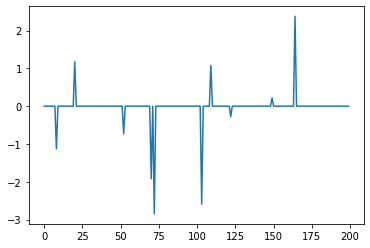

In [7]:
plt.plot(range(p),beta0)
plt.show()

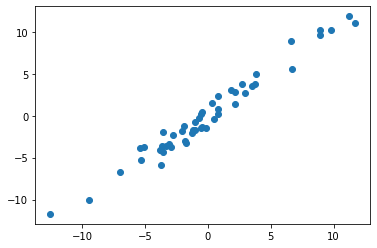

In [8]:
plt.plot(Y0.reshape(-1), X@beta0,'o')
plt.show()

Generate training and validation set

In [9]:
rng.seed(1)
gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
gamma_val, beta_val, Y_val = generator.generate_samples(10000)
Y_catXY_train = np.concatenate((Y_train, Y_train@X), axis=1)
Y_catXY_val = np.concatenate((Y_val, Y_val@X), axis=1)

Standardization

In [10]:
mean = Y_train.mean(0)
mean_catXY = Y_catXY_train.mean(0)
std = Y_train.std(0)
std_catXY = Y_catXY_train.std(0)
Y_train = (Y_train - mean) / std
Y_val = (Y_val - mean) / std
Y_catXY_train = (Y_catXY_train - mean_catXY) / std_catXY
Y_catXY_val = (Y_catXY_val - mean_catXY) / std_catXY

# Neural network functions

## Four layers MLP
* Four hidden layers, with 1024, 2048, 2048 and 1024 hidden units.

In [11]:
class MLP(nn.Module):
    def __init__(self, N, p):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss 
    
    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss 

In [12]:
''' 
 loss_type: 'mse' for posterior mean, 'bce' for predicting whether beta is 0, 'quantile' for posterior quantile.
q: Only used when loss_type is 'quantile', q quantile.
'''
def train_epoch(model, optimizer, train_data, train_labels, batch_size, loss_type, q):
    model.train()
    n = train_data.shape[0]
    train_loss = 0.
    for i in range(math.ceil(n/batch_size)):
        data = torch.from_numpy(train_data[(i*batch_size):min((i+1)*batch_size, n-1)]).type(torch.float).to(device)
        targ = torch.from_numpy(train_labels[(i*batch_size):min((i+1)*batch_size, n-1)]).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
        train_loss += loss.item() * data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/n 

def model_test(model, test_data, test_labels, loss_type='mse', q=0.5):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(test_data).type(torch.float).to(device)
        targ = torch.from_numpy(test_labels).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
    return loss.item()

def train_model(model, lr, batch_size, epochs, train_data, train_labels, loss_type='mse', q=0.5, val_data=None, val_labels=None):
    assert loss_type in ['mse', 'bce', 'quantile']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for i in range(epochs):
        train_loss = train_epoch(model, optimizer, train_data, train_labels, batch_size, loss_type, q)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if isinstance(val_data, np.ndarray):
            val_loss = model_test(model, val_data, val_labels, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
    return train_losses, val_losses

def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

In [24]:
def train_epoch_with_generator(model, optimizer, generator, batch_size, iteration, loss_type, q, catXY):
    model.train()
    train_loss = 0.
    for i in range(iteration):
        gamma, beta, Y = generator.generate_samples(batch_size)
        if catXY:
            Y = np.concatenate((Y, Y@X), axis=1)
            Y = (Y - mean_catXY) / std_catXY
        else:
            Y = (Y - mean) / std
        gamma = torch.from_numpy(gamma).type(torch.float).to(device)
        beta = torch.from_numpy(beta).type(torch.float).to(device)
        Y = torch.from_numpy(Y).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(Y, beta)
        elif loss_type == 'bce':
            loss = model.get_bceloss(Y, gamma)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(Y, beta, q)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/(i+1)

def train_model_with_generator(model, generator, lr, batch_size, epochs, iteration, catXY, loss_type='mse', q=0.5, val_data=None, val_labels=None):
    assert loss_type in ['mse', 'bce', 'quantile']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for i in range(epochs):
        model.train()
        train_loss = train_epoch_with_generator(model, optimizer, generator, batch_size, iteration, loss_type, q, catXY)
        print('Epoch: {}, Train loss {:.5f}'.format(i+1, train_loss))
        train_losses.append(train_loss)
        if isinstance(val_data, np.ndarray):
            val_loss = model_test(model, val_data, val_labels, loss_type, q)
            print("Val loss: {:.5f}".format(val_loss))
            val_losses.append(val_loss)
    return train_losses, val_losses

# Main experiments

In [13]:
torch.manual_seed(0)
md_base = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_base, 0.001, 256, 80, Y_train, beta_train, val_data=Y_val, val_labels=beta_val)

Epoch: 1
Train loss: 0.07121
Val loss: 0.05504
Epoch: 2
Train loss: 0.05034
Val loss: 0.05056
Epoch: 3
Train loss: 0.04719
Val loss: 0.04934
Epoch: 4
Train loss: 0.04569
Val loss: 0.04864
Epoch: 5
Train loss: 0.04466
Val loss: 0.04826
Epoch: 6
Train loss: 0.04379
Val loss: 0.04791
Epoch: 7
Train loss: 0.04299
Val loss: 0.04777
Epoch: 8
Train loss: 0.04224
Val loss: 0.04720
Epoch: 9
Train loss: 0.04148
Val loss: 0.04684
Epoch: 10
Train loss: 0.04076
Val loss: 0.04642
Epoch: 11
Train loss: 0.04000
Val loss: 0.04606
Epoch: 12
Train loss: 0.03923
Val loss: 0.04563
Epoch: 13
Train loss: 0.03844
Val loss: 0.04494
Epoch: 14
Train loss: 0.03764
Val loss: 0.04453
Epoch: 15
Train loss: 0.03677
Val loss: 0.04367
Epoch: 16
Train loss: 0.03586
Val loss: 0.04303
Epoch: 17
Train loss: 0.03487
Val loss: 0.04210
Epoch: 18
Train loss: 0.03372
Val loss: 0.04103
Epoch: 19
Train loss: 0.03261
Val loss: 0.04004
Epoch: 20
Train loss: 0.03175
Val loss: 0.03945
Epoch: 21
Train loss: 0.03118
Val loss: 0.03918
E

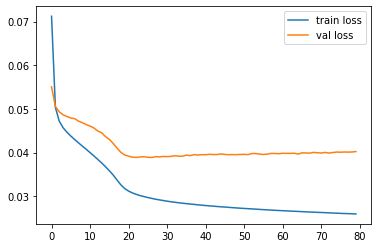

In [14]:
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(train_losses)), val_losses)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

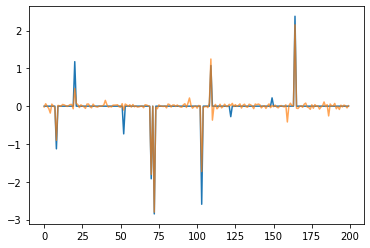

In [15]:
plt.plot(beta0)
plt.plot(predict(md_base, (Y0-mean)/std).reshape(-1), alpha=0.7)
plt.show()

In [16]:
torch.manual_seed(0)
md_withXY = MLP(N+p, p).to(device)
train_losses, val_losses = train_model(md_withXY, 0.001, 256, 80, Y_catXY_train, beta_train, val_data=Y_catXY_val, val_labels=beta_val)

Epoch: 1
Train loss: 0.07258
Val loss: 0.05925
Epoch: 2
Train loss: 0.05507
Val loss: 0.05528
Epoch: 3
Train loss: 0.05228
Val loss: 0.05388
Epoch: 4
Train loss: 0.05047
Val loss: 0.05263
Epoch: 5
Train loss: 0.04872
Val loss: 0.05093
Epoch: 6
Train loss: 0.04685
Val loss: 0.04940
Epoch: 7
Train loss: 0.04467
Val loss: 0.04712
Epoch: 8
Train loss: 0.04222
Val loss: 0.04461
Epoch: 9
Train loss: 0.03986
Val loss: 0.04288
Epoch: 10
Train loss: 0.03875
Val loss: 0.04250
Epoch: 11
Train loss: 0.03820
Val loss: 0.04242
Epoch: 12
Train loss: 0.03779
Val loss: 0.04242
Epoch: 13
Train loss: 0.03746
Val loss: 0.04216
Epoch: 14
Train loss: 0.03719
Val loss: 0.04197
Epoch: 15
Train loss: 0.03693
Val loss: 0.04178
Epoch: 16
Train loss: 0.03669
Val loss: 0.04168
Epoch: 17
Train loss: 0.03646
Val loss: 0.04142
Epoch: 18
Train loss: 0.03621
Val loss: 0.04114
Epoch: 19
Train loss: 0.03598
Val loss: 0.04079
Epoch: 20
Train loss: 0.03573
Val loss: 0.04040
Epoch: 21
Train loss: 0.03550
Val loss: 0.04008
E

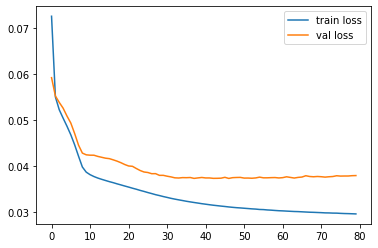

In [17]:
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(train_losses)), val_losses)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

In [ ]:
plt.plot(beta0)
plt.plot(predict(md_withXY, (Y0_catXY-mean_catXY)/std_catXY).reshape(-1), alpha=0.7)
plt.show()

In [25]:
torch.manual_seed(0)
rng.seed(3)
md_base_online = MLP(N, p).to(device)
train_losses, val_losses = train_model_with_generator(md_base_online, generator, 0.001, 256, 3000, 200, False, val_data=Y_val, val_labels=beta_val)

Epoch: 1, Train loss 0.14884
Val loss: 0.14381
Epoch: 2, Train loss 0.13880
Val loss: 0.13439
Epoch: 3, Train loss 0.12891
Val loss: 0.12777
Epoch: 4, Train loss 0.12597
Val loss: 0.12416
Epoch: 5, Train loss 0.12037
Val loss: 0.12158
Epoch: 6, Train loss 0.11887
Val loss: 0.12044
Epoch: 7, Train loss 0.12034
Val loss: 0.11970
Epoch: 8, Train loss 0.11940
Val loss: 0.11929
Epoch: 9, Train loss 0.11632
Val loss: 0.11916
Epoch: 10, Train loss 0.11708
Val loss: 0.11884


([0.14884268194437028,
  0.1387992709875107,
  0.12891054823994635,
  0.1259654641151428,
  0.1203670896589756,
  0.11886529251933098,
  0.12033964693546295,
  0.11939682513475418,
  0.1163238413631916,
  0.1170826457440853],
 [0.14381439983844757,
  0.1343913972377777,
  0.12777476012706757,
  0.12415575981140137,
  0.12158024311065674,
  0.12044120579957962,
  0.1197008565068245,
  0.11928601562976837,
  0.11916171759366989,
  0.11883510649204254])

In [ ]:
train_losses = []
val_losses = []
optimizer = torch.optim.Adam(model.parameters)
for i in range()

In [ ]:
Y_val_rho0 = np.load('./data/Y_val_rho0.npy')

# Some efforts we have made but doesn't work
* Add shrink activation function to the output layer